In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from transformers import BertTokenizer
from transformers import TFAutoModel

import tensorflow as tf

ModuleNotFoundError: No module named 'pandas'

In [3]:
!pip unins

  Using cached pandas-1.5.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
ERROR: Could not install packages due to an OSError: [Errno 122] Disk quota exceeded



In [2]:
df = pd.read_csv('../dataset/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
df.shape

(156060, 4)

### 1. Data Preprocessing

In [11]:
# Removing duplicate entries as we can see SentenceId to have multiple values
df.drop_duplicates(subset=['SentenceId'], keep='first').shape

(8529, 4)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

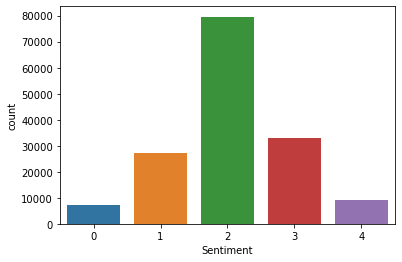

In [14]:
# Let's keep the duplicates as it is since it drastically reduces the dataset size
# Checking the distribution of data
# df['Sentiment'].value_counts().plot(kind='bar')
sns.countplot(x='Sentiment',data=df)

In [8]:
# Number of samples we want and the maximum seq length
seq_len, num_samples = 512, len(df)
num_samples, seq_len

(156060, 512)

In [9]:
# Initialize tokenizer
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Converting 'Phrase' text to numerical values
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,
                    truncation=True,
                    padding='max_length',
                    add_special_tokens=True,
                    return_tensors='np')

In [10]:
# Different elements in the token
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
# Saving the numpy arrays for later use
with open('../data/movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('../data/movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [12]:
# Getting the labels
y_train = df['Sentiment'].values
y_train.shape

(156060,)

In [13]:
# Converting it into 1-hot encoding
labels = np.zeros((num_samples, y_train.max()+1))
labels.shape

(156060, 5)

In [14]:
# Setting 1 at respective places, for all the rows make that respective value at index to 1
labels[np.arange(num_samples),y_train] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [15]:
with open('../data/movie-labels.npy', 'wb') as f:
    np.save(f, labels)

### 2. Building a Dataset

In [3]:
# Loading saved numpy array
with open('../data/movie-xids.npy', 'rb') as f:
    x_ids = np.load(f, allow_pickle=True)

with open('../data/movie-xmask.npy', 'rb') as f:
    x_mask = np.load(f, allow_pickle=True)

with open('../data/movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)


In [4]:
x_ids.shape, labels.shape

((156060, 512), (156060, 5))

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((x_ids, x_mask, labels))
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [22]:
# Mapping input_ids and attention mask together and labels
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids,
            'attention_mask': masks}, labels

dataset = dataset.map(map_func)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [23]:
# Shuffling the data, Batch and Split
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [26]:
# Split the data, 90% train and 10% test
split = 0.9
size = int((x_ids.shape[0] / batch_size)*split)
size

8778

In [29]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)
train_ds.element_spec, val_ds.element_spec

(({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
  TensorSpec(shape=(16, 5), dtype=tf.float64, name=None)),
 ({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
  TensorSpec(shape=(16, 5), dtype=tf.float64, name=None)))

In [28]:
# Saving the data
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

2022-09-19 16:12:53.212792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-19 16:12:53.217186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


In [30]:
# Loading the save data
train_ds = tf.data.experimental.load('train', train_ds.element_spec)
test_ds = tf.data.experimental.load('val', val_ds.element_spec)
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

### 3. Building and Saving the Model

In [7]:
model_name = 'bert-base-cased'
bert = TFAutoModel.from_pretrained(model_name)

bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


We need to define frame around the bert, we need:
1. Two input layers to the transformer i.e. the input_ids and the attention mask.
2. A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.
3. Max pooling layer to convert the 3D tensors output by BERT to 2D.
4. Final output activations using softmax for outputting categorical probabilities.


In [9]:
def build_model():
    # two input layers
    input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

    # using transformes within our bert object
    embeddings = bert.bert(input_ids, attention_mask=mask)[1]

    # Convert bert into 5 object class
    x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
    y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)
    
    # Initializing optimizer and loss
    optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy()
    auc, prec, recall = tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
    
    # Initializing the model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics=[acc, auc, prec, recall])
    
    return model

In [10]:
model = build_model()
model.summary()

/Users/shrikantkendre/miniforge3/envs/tfM1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [12]:
# Loading the dataset
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
   'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
  tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

train_ds.take(1)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [13]:
history = model.fit(train_ds,
                   validation_data = val_ds,
                   epochs=10)

Epoch 1/10


2022-09-20 16:24:45.015604: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-20 16:24:47.977569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 124/8778 [..............................] - ETA: 44:24:06 - loss: 1.2000 - categorical_accuracy: 0.5242 - auc: 0.8104 - precision: 0.6763 - recall: 0.3548

KeyboardInterrupt: 